In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Path("../model").mkdir(parents=True, exist_ok=True)
Path("../result").mkdir(parents=True, exist_ok=True)
Path("../data").mkdir(parents=True, exist_ok=True)

Using device: cuda


In [2]:
def load_data(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                words = [word for word in line.split() if word.strip()]
                if words:
                    sentences.append(words)
    return sentences

def words_to_chars_labels(sentences):
    char_sequences = []
    label_sequences = []
    
    for words in sentences:
        chars = []
        labels = []
        
        for word in words:
            word = word.strip()
            if len(word) == 1:
                chars.append(word)
                labels.append('S')
            elif len(word) > 1:
                chars.append(word[0])
                labels.append('B')
                for char in word[1:-1]:
                    chars.append(char)
                    labels.append('M')
                chars.append(word[-1])
                labels.append('E')
        
        if chars:
            char_sequences.append(chars)
            label_sequences.append(labels)
    
    return char_sequences, label_sequences

train_sentences = load_data("../data/icwb2-data/training/msr_training.utf8")
test_sentences = load_data("../data/icwb2-data/testing/msr_test.utf8")

train_chars, train_labels = words_to_chars_labels(train_sentences)
test_chars, test_labels = words_to_chars_labels(test_sentences)

print(f"训练集句子数量: {len(train_chars)}")
print(f"测试集句子数量: {len(test_chars)}")
print(f"训练集示例: {train_chars[0]}")
print(f"对应标签: {train_labels[0]}")

训练集句子数量: 86918
测试集句子数量: 3985
训练集示例: ['“', '人', '们', '常', '说', '生', '活', '是', '一', '部', '教', '科', '书', '，', '而', '血', '与', '火', '的', '战', '争', '更', '是', '不', '可', '多', '得', '的', '教', '科', '书', '，', '她', '确', '实', '是', '名', '副', '其', '实', '的', '‘', '我', '的', '大', '学', '’', '。']
对应标签: ['S', 'B', 'E', 'S', 'S', 'B', 'E', 'S', 'S', 'S', 'B', 'M', 'E', 'S', 'S', 'S', 'S', 'S', 'S', 'B', 'E', 'S', 'S', 'B', 'M', 'M', 'E', 'S', 'B', 'M', 'E', 'S', 'S', 'B', 'E', 'S', 'B', 'M', 'M', 'E', 'S', 'S', 'S', 'S', 'B', 'E', 'S', 'S']


In [3]:
class MaximumMatching:
    def __init__(self):
        self.word_dict = set()
        self.max_len = 0
    
    def build_dict(self, sentences):
        for words in sentences:
            for word in words:
                word = word.strip()
                if word:
                    self.word_dict.add(word)
                    self.max_len = max(self.max_len, len(word))
        
        print(f"词典大小: {len(self.word_dict)}")
        print(f"最大词长: {self.max_len}")
    
    def forward_max_matching(self, text):
        result = []
        i = 0
        
        while i < len(text):
            matched = False
            for length in range(min(self.max_len, len(text) - i), 0, -1):
                word = text[i:i+length]
                if word in self.word_dict:
                    result.append(word)
                    i += length
                    matched = True
                    break
            
            if not matched:
                result.append(text[i])
                i += 1
        
        return result
    
    def backward_max_matching(self, text):
        result = []
        i = len(text)
        
        while i > 0:
            matched = False
            for length in range(min(self.max_len, i), 0, -1):
                word = text[i-length:i]
                if word in self.word_dict:
                    result.insert(0, word)
                    i -= length
                    matched = True
                    break
            
            if not matched:
                result.insert(0, text[i-1])
                i -= 1
        
        return result
    
    def bidirectional_matching(self, text):
        forward_result = self.forward_max_matching(text)
        backward_result = self.backward_max_matching(text)
        
        if len(forward_result) < len(backward_result):
            return forward_result
        elif len(forward_result) > len(backward_result):
            return backward_result
        else:
            forward_single = sum(1 for word in forward_result if len(word) == 1)
            backward_single = sum(1 for word in backward_result if len(word) == 1)
            
            if forward_single <= backward_single:
                return forward_result
            else:
                return backward_result

mm_model = MaximumMatching()
mm_model.build_dict(train_sentences)

词典大小: 88119
最大词长: 48


In [4]:
class ChineseSegmentationDataset(Dataset):
    
    def __init__(self, char_sequences, label_sequences, char2idx, label2idx):
        self.char_sequences = char_sequences
        self.label_sequences = label_sequences
        self.char2idx = char2idx
        self.label2idx = label2idx
    
    def __len__(self):
        return len(self.char_sequences)
    
    def __getitem__(self, idx):
        chars = self.char_sequences[idx]
        labels = self.label_sequences[idx]
        
        # 转换为索引
        char_indices = [self.char2idx.get(char, self.char2idx['<UNK>']) for char in chars]
        label_indices = [self.label2idx[label] for label in labels]
        
        return torch.tensor(char_indices), torch.tensor(label_indices)

def collate_fn(batch):
    chars, labels = zip(*batch)
    
    max_len = max(len(seq) for seq in chars)
    
    padded_chars = []
    padded_labels = []
    lengths = []
    
    for char_seq, label_seq in zip(chars, labels):
        length = len(char_seq)
        lengths.append(length)
        
        padded_char = torch.cat([char_seq, torch.zeros(max_len - length, dtype=torch.long)])
        padded_label = torch.cat([label_seq, torch.zeros(max_len - length, dtype=torch.long)])
        
        padded_chars.append(padded_char)
        padded_labels.append(padded_label)
    
    return torch.stack(padded_chars), torch.stack(padded_labels), torch.tensor(lengths)

class BiLSTMCRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags, dropout=0.1):
        super(BiLSTMCRF, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_tags = num_tags

        self.char_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, 
                           num_layers=2, bidirectional=True, 
                           dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.hidden2tag = nn.Linear(hidden_dim, num_tags)
        
        self.transitions = nn.Parameter(torch.randn(num_tags, num_tags))
        
        self.init_weights()
    
    def init_weights(self):
        nn.init.xavier_uniform_(self.char_embeddings.weight)
        nn.init.xavier_uniform_(self.hidden2tag.weight)
        nn.init.constant_(self.hidden2tag.bias, 0)
    
    def forward(self, chars, lengths):
        batch_size, seq_len = chars.size()
        
        embeddings = self.char_embeddings(chars)
        
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(
            embeddings, lengths, batch_first=True, enforce_sorted=False
        )

        packed_lstm_out, _ = self.lstm(packed_embeddings)
        
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(packed_lstm_out, batch_first=True)
        
        lstm_out = self.dropout(lstm_out)
        
        tag_scores = self.hidden2tag(lstm_out)
        
        return tag_scores
    
    def crf_loss(self, emissions, tags, lengths):
        batch_size, seq_len, num_tags = emissions.size()
        
        def forward_algorithm(emissions, transitions):
            batch_size, seq_len, num_tags = emissions.size()
            alpha = torch.full((batch_size, num_tags), -10000.0, device=emissions.device)
            alpha[:, 0] = emissions[:, 0, 0]
            
            for i in range(1, seq_len):
                alpha_t = alpha.unsqueeze(2) + transitions.unsqueeze(0) + emissions[:, i].unsqueeze(1)
                alpha = torch.logsumexp(alpha_t, dim=1)
            
            return torch.logsumexp(alpha, dim=1)
        
        def score_sentence(emissions, tags, transitions):
            batch_size, seq_len = tags.size()
            score = torch.zeros(batch_size, device=emissions.device)
            
            score += emissions[range(batch_size), 0, tags[:, 0]]
            
            for i in range(1, seq_len):
                score += transitions[tags[:, i-1], tags[:, i]]
                score += emissions[range(batch_size), i, tags[:, i]]
            
            return score
        
        forward_score = forward_algorithm(emissions, self.transitions)
        
        gold_score = score_sentence(emissions, tags, self.transitions)
        
        # 计算损失
        loss = forward_score - gold_score
        
        return loss.mean()

print("BiLSTM-CRF模型定义完成")

BiLSTM-CRF模型定义完成


In [5]:
def build_vocab(char_sequences):
    char_counter = Counter()
    for chars in char_sequences:
        char_counter.update(chars)
    
    char2idx = {'<PAD>': 0, '<UNK>': 1}
    for char, count in char_counter.most_common():
        if count >= 1:  # 最小频次阈值
            char2idx[char] = len(char2idx)
    
    idx2char = {idx: char for char, idx in char2idx.items()}
    return char2idx, idx2char

label2idx = {'<PAD>': 0, 'B': 1, 'M': 2, 'E': 3, 'S': 4}
idx2label = {idx: label for label, idx in label2idx.items()}

char2idx, idx2char = build_vocab(train_chars)

print(f"字符词汇表大小: {len(char2idx)}")
print(f"标签数量: {len(label2idx)}")

train_dataset = ChineseSegmentationDataset(train_chars, train_labels, char2idx, label2idx)
test_dataset = ChineseSegmentationDataset(test_chars, test_labels, char2idx, label2idx)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"训练批次数: {len(train_loader)}")
print(f"测试批次数: {len(test_loader)}")

字符词汇表大小: 5169
标签数量: 5
训练批次数: 340
测试批次数: 16


In [6]:
vocab_size = len(char2idx)
embedding_dim = 128
hidden_dim = 256
num_tags = len(label2idx)
learning_rate = 0.001
num_epochs = 20

model = BiLSTMCRF(vocab_size, embedding_dim, hidden_dim, num_tags).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for chars, labels, lengths in tqdm(train_loader, desc="Training"):
        chars = chars.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # 前向传播
        emissions = model(chars, lengths)
        
        # 计算损失
        loss = model.crf_loss(emissions, labels, lengths)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_simple(model, test_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for chars, labels, lengths in test_loader:
            chars = chars.to(device)
            labels = labels.to(device)
            
            emissions = model(chars, lengths)
            
            loss = model.crf_loss(emissions, labels, lengths)
            total_loss += loss.item()
            
            predictions = torch.argmax(emissions, dim=-1)
            
            for i, length in enumerate(lengths):
                pred = predictions[i, :length]
                true = labels[i, :length]
                correct += (pred == true).sum().item()
                total += length.item()
    
    accuracy = correct / total if total > 0 else 0
    avg_loss = total_loss / len(test_loader)
    
    return avg_loss, accuracy

train_losses = []
val_losses = []
val_accuracies = []

print("开始训练BiLSTM模型...")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    
    val_loss, val_acc = evaluate_simple(model, test_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {val_acc:.4f}')
        print('-' * 50)

torch.save({
    'model_state_dict': model.state_dict(),
    'char2idx': char2idx,
    'idx2char': idx2char,
    'label2idx': label2idx,
    'idx2label': idx2label,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'hidden_dim': hidden_dim,
    'num_tags': num_tags
}, '../model/bilstm_segmentation.pth')

print("模型训练完成并已保存")

开始训练BiLSTM模型...


Training: 100%|██████████| 340/340 [01:05<00:00,  5.22it/s]


Epoch [10/20]
Train Loss: -1349.4100
Val Loss: -1188.7898
Val Accuracy: 0.1359
--------------------------------------------------


Training: 100%|██████████| 340/340 [01:06<00:00,  5.12it/s]


Epoch [20/20]
Train Loss: -2882.6780
Val Loss: -2662.8617
Val Accuracy: 0.1414
--------------------------------------------------
模型训练完成并已保存


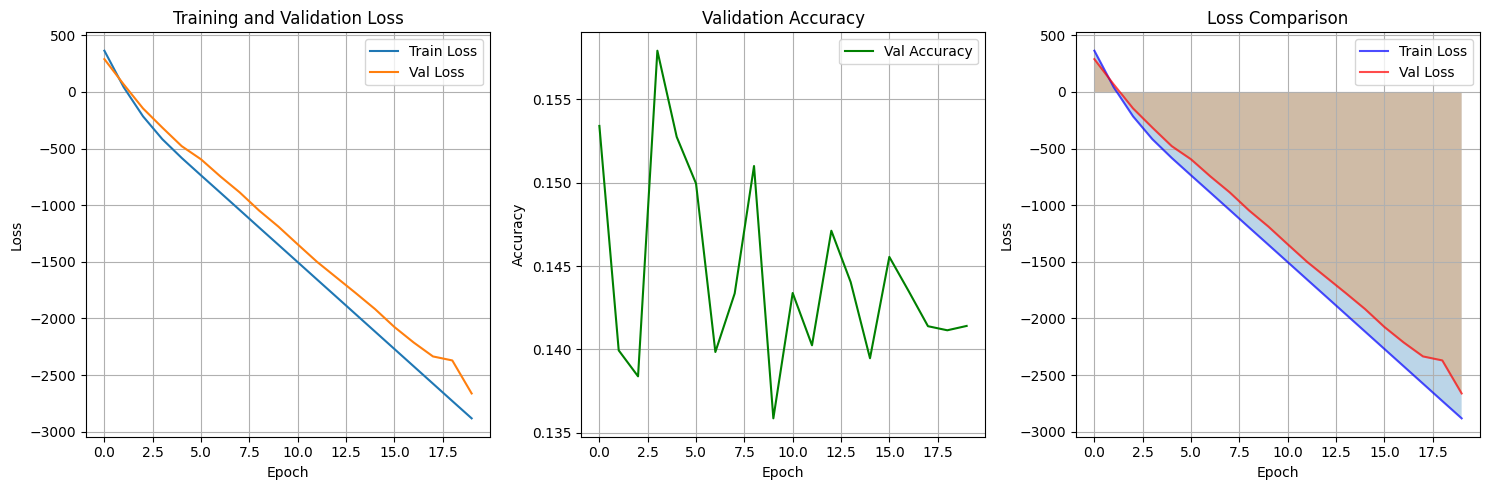

最终验证准确率: 0.1414
最终训练损失: -2882.6780
最终验证损失: -2662.8617


In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(len(train_losses)), train_losses, 'b-', alpha=0.7, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, 'r-', alpha=0.7, label='Val Loss')
plt.fill_between(range(len(train_losses)), train_losses, alpha=0.3)
plt.fill_between(range(len(val_losses)), val_losses, alpha=0.3)
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('../result/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"最终验证准确率: {val_accuracies[-1]:.4f}")
print(f"最终训练损失: {train_losses[-1]:.4f}")
print(f"最终验证损失: {val_losses[-1]:.4f}")

In [12]:
def bilstm_segment(model, text, char2idx, idx2label, device):
    model.eval()
    
    char_indices = [char2idx.get(char, char2idx['<UNK>']) for char in text]
    chars_tensor = torch.tensor([char_indices]).to(device)
    lengths = torch.tensor([len(char_indices)])
    
    with torch.no_grad():
        emissions = model(chars_tensor, lengths)
        
        predictions = torch.argmax(emissions, dim=-1)
        pred_labels = [idx2label[pred.item()] for pred in predictions[0]]
    
    words = []
    current_word = ""
    
    for char, label in zip(text, pred_labels):
        if label == 'B':
            if current_word:
                words.append(current_word)
            current_word = char
        elif label == 'M':
            current_word += char
        elif label == 'E':
            current_word += char
            words.append(current_word)
            current_word = ""
        elif label == 'S':
            if current_word:
                words.append(current_word)
            words.append(char)
            current_word = ""
    
    if current_word:
        words.append(current_word)
    
    return words

def compare_segmentation_methods(text):
    print(f"原文: {text}")
    print("-" * 50)
    
    mm_result = mm_model.bidirectional_matching(text)
    print(f"最大匹配算法: {' / '.join(mm_result)}")
    
    bilstm_result = bilstm_segment(model, text, char2idx, idx2label, device)
    print(f"BiLSTM算法: {' / '.join(bilstm_result)}")
    
    print("=" * 50)
    return mm_result, bilstm_result

test_texts = [
    "我爱北京天安门",
    "机器学习是人工智能的重要分支",
    "今天天气很好",
    "自然语言处理技术发展迅速",
    "北京大学是著名的高等学府"
]

print("分词结果比较:")
print("=" * 50)

results = {}
for text in test_texts:
    mm_result, bilstm_result = compare_segmentation_methods(text)
    results[text] = {
        'max_matching': mm_result,
        'bilstm': bilstm_result
    }

分词结果比较:
原文: 我爱北京天安门
--------------------------------------------------
最大匹配算法: 我 / 爱 / 北京 / 天安门
BiLSTM算法: 我 / 爱 / 北京 / 天 / 安门
原文: 机器学习是人工智能的重要分支
--------------------------------------------------
最大匹配算法: 机器 / 学习 / 是 / 人工智能 / 的 / 重要 / 分支
BiLSTM算法: 机器 / 学习 / 是 / 人工 / 智能 / 的 / 重要 / 分支
原文: 今天天气很好
--------------------------------------------------
最大匹配算法: 今天 / 天气 / 很 / 好
BiLSTM算法: 今天 / 天气 / 很 / 好
原文: 自然语言处理技术发展迅速
--------------------------------------------------
最大匹配算法: 自然 / 语言 / 处理 / 技术 / 发展 / 迅速
BiLSTM算法: 自然 / 语言 / 处理 / 技术 / 发展 / 迅速
原文: 北京大学是著名的高等学府
--------------------------------------------------
最大匹配算法: 北京大学 / 是 / 著名 / 的 / 高等 / 学府
BiLSTM算法: 北京大学 / 是 / 著 / 的 / 高等 / 学 / 府


In [14]:
import json

# 保存详细结果
detailed_results = {
    'training_info': {
        'epochs': num_epochs,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'final_val_accuracy': val_accuracies[-1],
        'vocab_size': vocab_size,
        'model_parameters': sum(p.numel() for p in model.parameters())
    },
    'segmentation_results': results
}

with open('../result/segmentation_results.json', 'w', encoding='utf-8') as f:
    json.dump(detailed_results, f, ensure_ascii=False, indent=2)

training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}

with open('../result/training_history.json', 'w', encoding='utf-8') as f:
    json.dump(training_history, f, indent=2)

summary_data = []
for text, result in results.items():
    summary_data.append({
        '原文': text,
        '最大匹配': ' / '.join(result['max_matching']),
        'BiLSTM': ' / '.join(result['bilstm']),
        '最大匹配词数': len(result['max_matching']),
        'BiLSTM词数': len(result['bilstm'])
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../result/segmentation_comparison.csv', index=False, encoding='utf-8')

print("实验总结:")
print("=" * 60)
print(f"1. 数据集: MSR中文分词数据集")
print(f"2. 训练样本数: {len(train_chars)}")
print(f"3. 测试样本数: {len(test_chars)}")
print(f"4. 字符词汇表大小: {vocab_size}")
print(f"5. 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"6. 最终验证准确率: {val_accuracies[-1]:.4f}")
print(f"7. 训练轮数: {num_epochs}")
print(f"8. 使用设备: {device}")
print("=" * 60)

print("\n分词方法比较:")
print(summary_df.to_string(index=False))

print(f"\n所有结果已保存到 ../result/ 目录")
print(f"模型已保存到 ../model/ 目录")
print("\n实验完成!")

实验总结:
1. 数据集: MSR中文分词数据集
2. 训练样本数: 86918
3. 测试样本数: 3985
4. 字符词汇表大小: 5169
5. 模型参数数量: 1,322,398
6. 最终验证准确率: 0.1414
7. 训练轮数: 20
8. 使用设备: cuda

分词方法比较:
            原文                             最大匹配                              BiLSTM  最大匹配词数  BiLSTM词数
       我爱北京天安门                 我 / 爱 / 北京 / 天安门                 我 / 爱 / 北京 / 天 / 安门       4         5
机器学习是人工智能的重要分支 机器 / 学习 / 是 / 人工智能 / 的 / 重要 / 分支 机器 / 学习 / 是 / 人工 / 智能 / 的 / 重要 / 分支       7         8
        今天天气很好                  今天 / 天气 / 很 / 好                     今天 / 天气 / 很 / 好       4         4
  自然语言处理技术发展迅速      自然 / 语言 / 处理 / 技术 / 发展 / 迅速         自然 / 语言 / 处理 / 技术 / 发展 / 迅速       6         6
  北京大学是著名的高等学府      北京大学 / 是 / 著名 / 的 / 高等 / 学府       北京大学 / 是 / 著 / 的 / 高等 / 学 / 府       6         7

所有结果已保存到 ../result/ 目录
模型已保存到 ../model/ 目录

实验完成!
